C:\Users\dhoan\AppData\Local\Temp\ipykernel_20288\1337318946.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"D:\MLP-handwriting\Code\

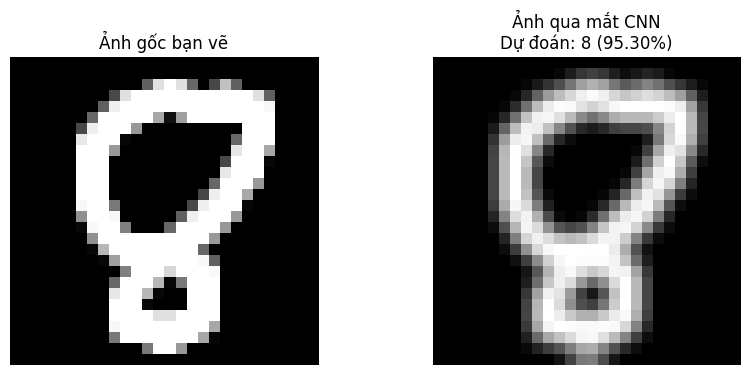

Xác suất chi tiết:
Số 0: 0.00%
Số 1: 0.00%
Số 2: 0.28%
Số 3: 0.00%
Số 4: 0.00%
Số 5: 0.00%
Số 6: 4.21%
Số 7: 0.00%
Số 8: 95.30%
Số 9: 0.20%


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# 1. Đảm bảo class CNN được định nghĩa đúng (phải giống hệt lúc bạn train)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 14 * 14, 128) # Changed from 64 * 7 * 7 to 64 * 14 * 14
        self.fc2 = nn.Linear(128, 10) # Changed from 64 to 10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        # Removed softmax here as F.softmax is applied later in run_final_test
        return x

def run_final_test(image_path, model, device):
    if not os.path.exists(image_path):
        print(f"❌ Không tìm thấy file tại: {image_path}")
        return

    # 2. Tiền xử lý quan trọng nhất: Resize + Blur + Normalize
    # GaussianBlur giúp làm dày nét vẽ mảnh 1-pixel của Pixilart
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.GaussianBlur(kernel_size=3, sigma=1.0),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # 3. Chuẩn bị ảnh
    img = Image.open(image_path).convert('L')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # 4. Dự đoán
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = torch.max(probabilities).item() * 100

    # 5. Hiển thị kết quả trực quan
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Ảnh gốc bạn vẽ
    ax1.imshow(img, cmap='gray')
    ax1.set_title("Ảnh gốc bạn vẽ")
    ax1.axis('off')

    # Ảnh mô hình thực sự nhìn thấy (đã qua tiền xử lý)
    img_processed = img_tensor.cpu().squeeze().numpy()
    ax2.imshow(img_processed, cmap='gray')
    ax2.set_title(f"Ảnh qua mắt CNN\nDự đoán: {prediction} ({confidence:.2f}%)")
    ax2.axis('off')

    plt.show()

    # In ra xác suất của từng số để xem mô hình phân vân thế nào
    print("Xác suất chi tiết:")
    for i, p in enumerate(probabilities[0]):
        print(f"Số {i}: {p.item()*100:.2f}%")

# --- THỰC THI ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Load model có sẵn
model=CNN().to(device)
model.load_state_dict(torch.load(r"D:\MLP-handwriting\Code\mnist_cnnv2.pth", map_location=device))



# Lưu ý: Đảm bảo biến 'model' của bạn đã được train và đang nằm trong bộ nhớ
# Nếu bạn vừa khởi tạo lại model, hãy nhớ load_state_dict trước khi chạy dòng này.
path = r"D:\MLP-handwriting\Code\data\SELF_TEST\8.png"
run_final_test(path, model, device)